In [18]:
import pathlib
import os
import warnings
from typing import NamedTuple

from fsspec.implementations.local import LocalFileSystem
from PIL import Image
from hydra import compose, initialize
import polars as pl
import seaborn as sns
from matplotlib import ticker


In [19]:
from tr_learn.data.utils import get_split_and_class

In [20]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [21]:
%matplotlib inline

In [22]:
with initialize(os.path.join("configs", "data"), version_base="1.3"):
    config = compose("plates")

In [23]:
class ImageInfo(NamedTuple):
    width: int
    height: int
    num_channels: int
    label: str
    split: str

In [24]:
def get_info_about_image(file_obj, split: str, label: str) -> ImageInfo:
    with Image.open(file_obj) as img:
        return ImageInfo(
            img.width,
            img.height,
            len(img.getbands()),
            label,
            split
        )

In [25]:
fs = LocalFileSystem(config.path_to_data)

In [26]:
info = []

In [27]:
for file in fs.find("/", detail=False):
    image_path = pathlib.Path(file)

    if image_path.suffix.lower() != ".jpg":
        continue

    split, label = get_split_and_class(image_path)
    
    with fs.open(file) as f: 
        info.append(get_info_about_image(f, split, label))

In [28]:
info = pl.from_records(info, {"width": pl.UInt16, "height": pl.UInt16, "num_channels": pl.Int8, "label": pl.Utf8, "split": pl.Utf8})

In [29]:
info = info.with_columns((pl.col("width") / pl.col("height")).round(3).alias("aspect"))

In [30]:
info.get_column("num_channels").n_unique()

1

In [31]:
info.select(pl.col("split").value_counts(sort=True))

split
struct[2]
"{""test"",744}"
"{""train"",40}"


In [32]:
info = info.with_columns(
    (pl.col("width").cast(pl.Utf8) + "x" + pl.col("height").cast(pl.Utf8)).alias("size")
)

In [33]:
size_counts = info.group_by("split", "size").count().with_columns(pl.col("count").sum().over("split").alias("total")).with_columns(
    pl.col("count") / pl.col("total")
)

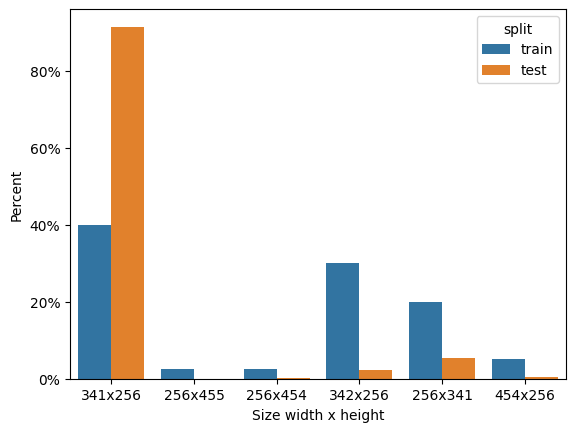

In [34]:
ax = sns.barplot(size_counts.to_pandas(), x="size", y="count", hue="split")
ax.set_xlabel("Size width x height")
ax.set_ylabel("Percent")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))